In [283]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
from datetime import datetime
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt

In [284]:
train = pd.read_csv("datasets/train.csv")
test = pd.read_csv("datasets/test.csv")

In [285]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


In [286]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988,40.732,-73.990,40.757,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964,40.680,-73.960,40.655,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997,40.738,-73.986,40.730,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956,40.772,-73.986,40.730,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970,40.761,-73.962,40.756,N


In [287]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


In [288]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [289]:
test.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

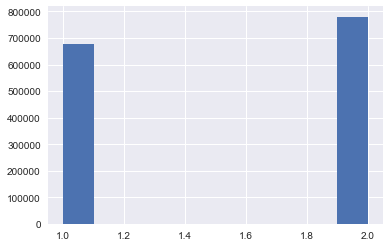

In [290]:
train['vendor_id'].hist()

In [291]:
train['vendor_id'].value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

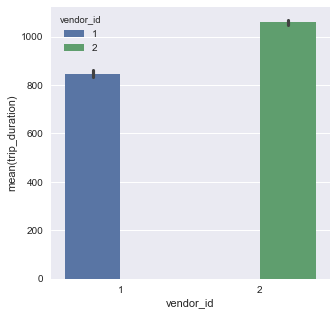

In [292]:
# vendorid having 2 seems to have a larger duration
fig,axes = plt.subplots(figsize = (5,5))
sns.barplot(data=train, x='vendor_id',y='trip_duration',hue='vendor_id')

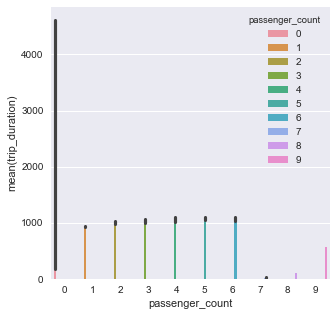

In [293]:
# Number of people fom 1 to 6 almost have same time to travel as opposed to 7 to 9.
fig,axes = plt.subplots(figsize = (5,5))
sns.barplot(data=train, x='passenger_count',y='trip_duration',hue='passenger_count')

NYC Border limits are such that 
city_long_border = (-74.03, -73.75) city_lat_border = (40.63, 40.85)
With that being defined, the rest of the other points we could sufficiently assume other datapoints are outliers.

In [294]:
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


In [295]:
train.shape

(1439183, 11)

In [296]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
print("Mean: {:.3f}  Standard Dev:{:.3f}".format(m,s))
Train = train[train['trip_duration'] <= m + 2*s]
Train = train[train['trip_duration'] >= m - 2*s]

Mean: 946.231  Standard Dev:5251.641


In [297]:
Train.shape

(1439183, 11)

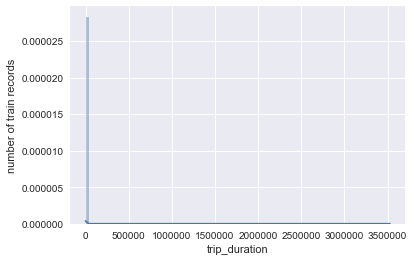

In [303]:
sns.distplot(a=train['trip_duration'],bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

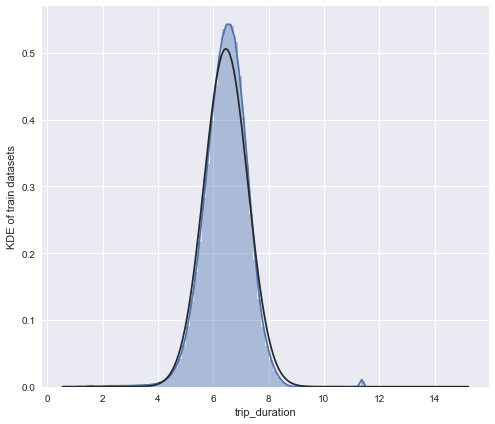

In [327]:
fig,axes = plt.subplots(figsize=(8,7))
plt.ylabel('KDE of train datasets')
plt.xlabel('log of Trip Duration')
sns.distplot(a=np.log1p(Train['trip_duration']),bins=100, fit=stats.norm)

In [301]:
Train['log_trip_duration'] = np.log1p(Train['trip_duration'])

In [336]:
Test = test

In [337]:
Train['pickup_datetime_converted'] =pd.to_datetime(Train['pickup_datetime']) 
Test['pickup_datetime_converted'] =pd.to_datetime(Test['pickup_datetime']) 

In [339]:
Train.loc[:, 'pickup_date'] = Train['pickup_datetime_converted'].dt.date
Test.loc[:, 'pickup_date'] = Test['pickup_datetime_converted'].dt.date

In [340]:
Train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_datetime_converted,pickup_date
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,6.122,2016-03-14 17:24:55,2016-03-14
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,6.498,2016-06-12 00:43:35,2016-06-12
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,7.662,2016-01-19 11:35:24,2016-01-19
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,6.064,2016-04-06 19:32:31,2016-04-06
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,6.078,2016-03-26 13:30:55,2016-03-26


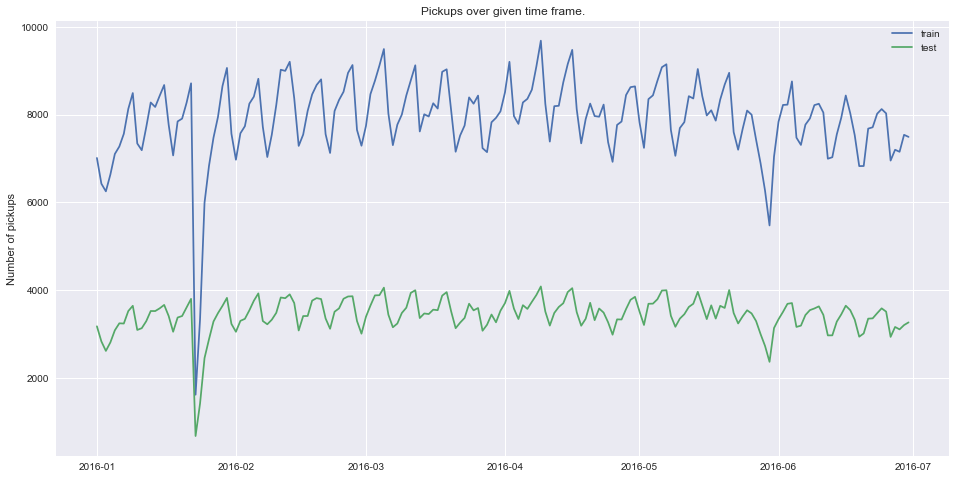

In [353]:
fig,axes = plt.subplots(figsize =(16,8))
plt.plot(Train.groupby('pickup_date').count()[['id']], 'x-', label='train')
plt.plot(Test.groupby('pickup_date').count()[['id']], 'x-', label='test')
plt.title('Pickups over given time frame.')
plt.legend(loc=0)
plt.ylabel('Number of pickups')

In [357]:
Train.groupby('vendor_id')['trip_duration'].mean()

vendor_id
1    833.503
2   1044.231
Name: trip_duration, dtype: float64

In [358]:
Train.groupby('store_and_fwd_flag')['trip_duration'].mean()

store_and_fwd_flag
N    945.569
Y   1066.472
Name: trip_duration, dtype: float64

In [359]:
Train.groupby('passenger_count')['trip_duration'].mean()

passenger_count
0   1880.925
1    917.370
2    990.569
3   1013.873
4   1037.515
5   1058.289
6   1050.980
Name: trip_duration, dtype: float64

In [360]:
Train.groupby('passenger_count').size()

passenger_count
0         53
1    1019950
2     207167
3      59104
4      28011
5      77127
6      47771
dtype: int64